[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_yolov5.ipynb)

# Inference on YOLOv8 using Slicing Aided Hyper Inference Technique

## For this inference notebook, packages such as SAHI, Ultralytics, OpenCV and NumPy are required to be installed.



**NOTE:** After running this cell, the runtime needs to be restarted. After that is done, you can continue with the other cells.

For restarting the runtime, follow this:



1.   Runtime -> Restart Runtime
2.   (or) just press *Ctrl + M*






In [1]:
pwd

'/mmfs1/scratch/dsu.local/bshakya/scratch/bshakya/sahi'

## In this inference notebook, we will be using a pretrained YOLOv8-S model, as the Object Detector.

This cell imports the model functions and classes from the SAHI directory.

#### **Model Initialization**

In [6]:
# Import YOLOv8-S model
#rom sahi.utils.yolov8 import (
 #   download_yolov8s_model,
#)

# Import required functions and classes
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image, read_image_as_pil
from sahi.utils.file import Path, increment_path, list_files, save_json, save_pickle, download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict, agg_prediction
from sahi.prediction import visualize_object_predictions
from IPython.display import Image
from numpy import asarray
import cv2
import os

This cell downloads the YOLOv8-S model and few test_images to perform inference.

In [7]:
# Download YOLOv8-S model to 'models/yolov8s.pt'
yolov8_model_path = 'models/yolov8/last.pt'
#download_yolov8s_model(destination_path=yolov8_model_path)

**Perform Inference on YOLOv8-S model (without and with SAHI)**

In this cell, a detection model has been initialized by defining the model weight path, and other necessary parameters such as confidence_threshold and device.

**NOTE:** If you have an Nvidia GPU for CUDA acceleration, then set `device='cuda:0'` otherwise, leave it as `device='cpu'`.

In [8]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.3,
    device="cuda:0", # or 'cpu'
)

## Perform Inference and Visualize (without SAHI)

In [5]:
!pip install -U scikit-image imagecodecs

Defaulting to user installation because normal site-packages is not writeable


In [44]:
result2 = get_sliced_prediction(
    "test_visdrone_data/images/0000074_03738_d_0000007.jpg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.5,
    overlap_width_ratio = 0.5,
    postprocess_type = "NMS",
    verbose = 2
)

Performing prediction on 28 slices.
Slicing performed in 0.012993097305297852 seconds.
Prediction performed in 0.8646807670593262 seconds.


In [31]:
result3 = get_sliced_prediction(
    "test_data/0000370_02000_d_0000254.jpg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.5,
    overlap_width_ratio = 0.5,
    verbose = 2
)

Performing prediction on 10 slices.
Slicing performed in 0.0055751800537109375 seconds.
Prediction performed in 0.17889618873596191 seconds.


In [32]:
object_density = len(result3.to_coco_annotations())
object_density

4

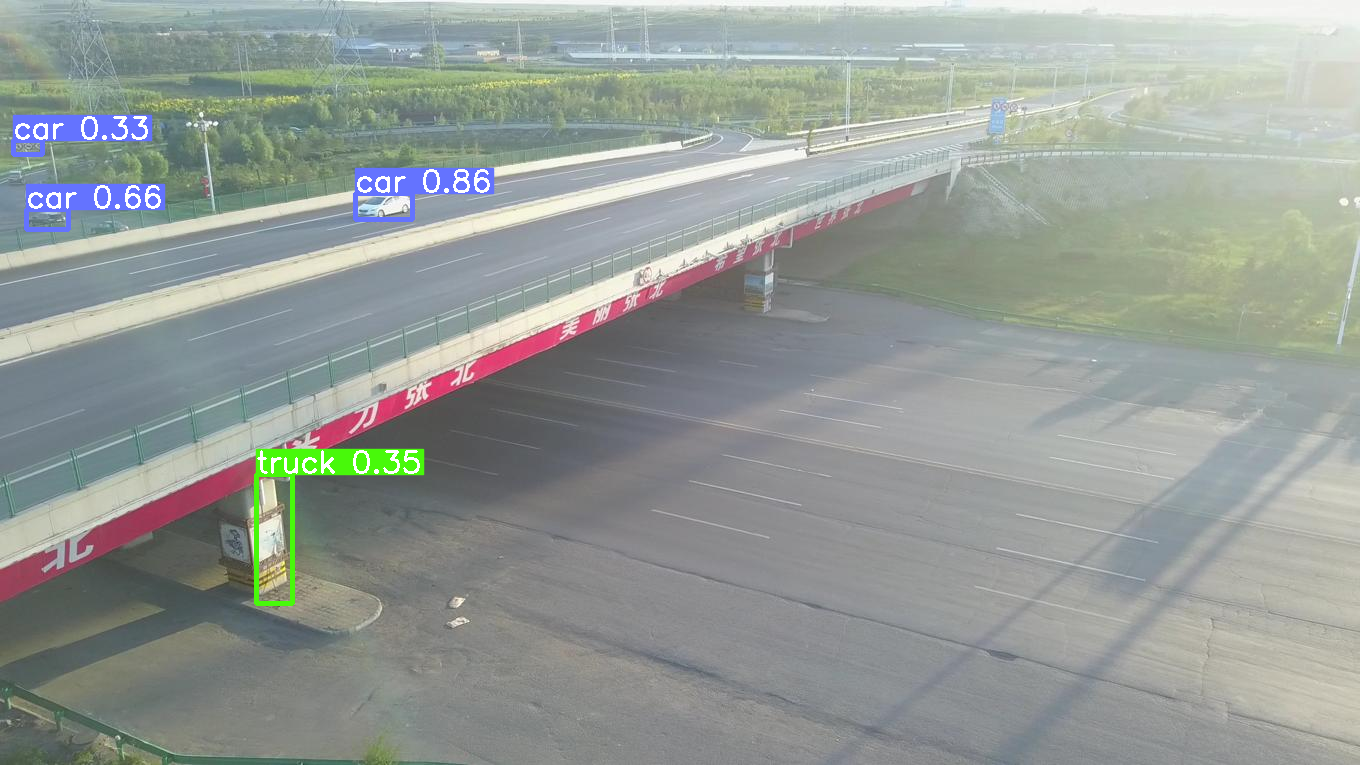

In [33]:
result3.export_visuals(export_dir="demo_data/")
Image("demo_data/prediction_visual.png")

In [35]:
object_density = len(result2.to_coco_annotations())
object_density

87

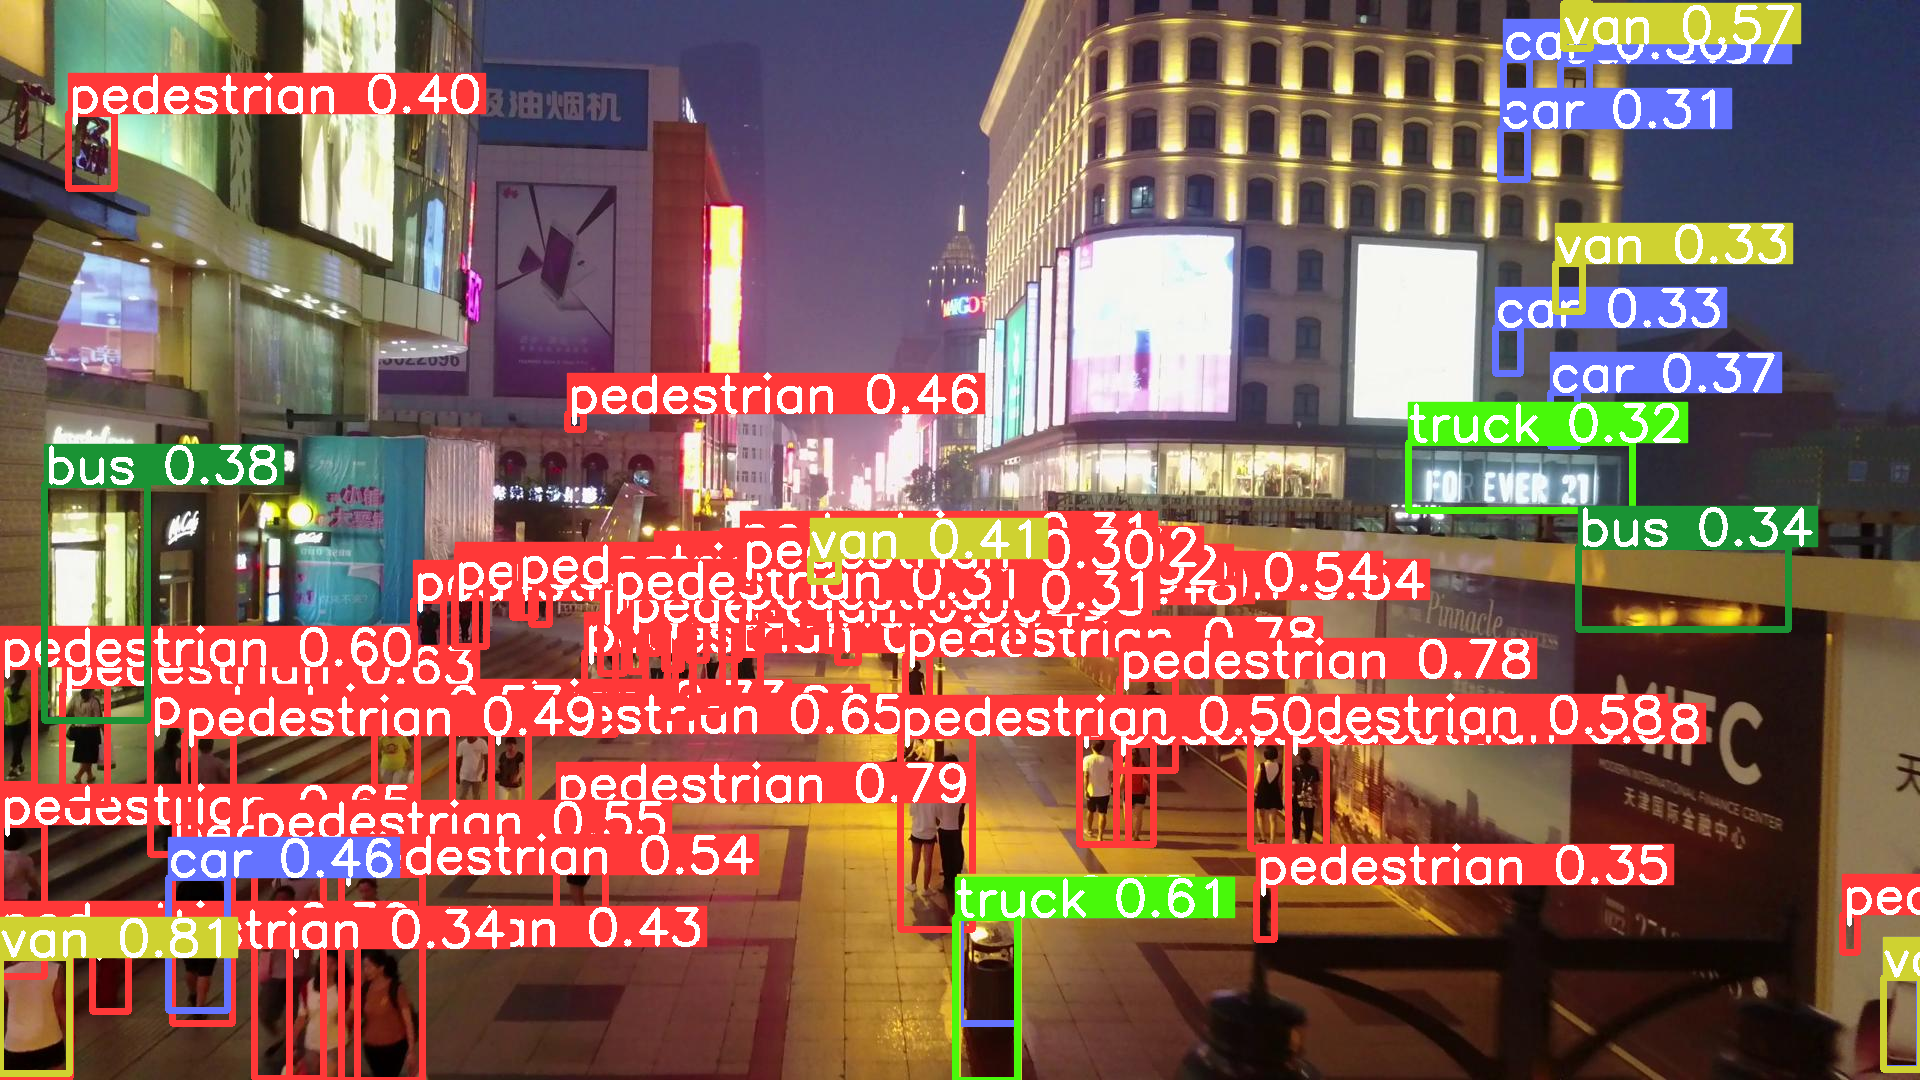

In [36]:
result2.export_visuals(export_dir="demo_data/")
Image("demo_data/prediction_visual.png")

In [ ]:
from pathlib import Path

def increment_path_fn(path, exist_ok=False, sep='_'):
    """
    Increment path, i.e. runs path, path_1, path_2, ... 
    if exist_ok is False and the given path already exists.
    
    Parameters:
        path (Path or str): Base path.
        exist_ok (bool): If True, will return the original path even if it exists.
        sep (str): Separator to use between path name and the index.
    
    Returns:
        str: A unique path string.
    """
    path = Path(path)
    print(path)
    if path.exists() and not exist_ok:
        # Get a parent directory and the stem (base name)
        parent, stem = path.parent, path.stem
        # Get the extension if it exists
        ext = path.suffix
        
        # Start incrementing from 1 until a unique path is found
        i = 1
        while True:
            new_path = parent / f"{stem}{sep}{i}{ext}"
            if not new_path.exists():
                path = new_path
                break
            i += 1
    return str(path)

# Example usage:
#name = "exp"
#save_dir = Path(increment_path1(Path("intial_predictions") / name, exist_ok=False))
#os.makedirs(save_dir, exist_ok=True)
#print("Unique save directory:", save_dir)

In [ ]:
!rm -rf intial_predictions

In [ ]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm
from sahi.prediction import ObjectPrediction, PredictionResult

# export visualization
def predict_images(input_folder, detection_model):
    """
    Processes all image files in input_folder:
      - Runs predictions using get_prediction function and detection_model.
      - Saves annotated images with bounding boxes in output_folder.
      - Saves prediction details as JSON files in output_folder.
    
    Parameters:
      input_folder (str): Path to the folder containing images.
      output_folder (str): Path to the folder where results will be saved.
      detection_model: Your detection model used for prediction.
    """
    name = "exp"
    save_dir = Path(increment_path(Path("intial_predictions") / name, exist_ok=False))
    os.makedirs(save_dir, exist_ok=True)
    
    color = (0, 255, 0)  # original annotations in green
    visual_bbox_gt_thickness = 3
    visual_bbox_thickness = 2
    visual_text_size = 0.5
    visual_text_thickness = 1
    visual_hide_labels = False
    visual_hide_conf = False
    visual_export_format = 'png'
    #file_name = 'result_gt'
    #filename_prediction = 'prediction_visual_with_gt'
    #output_dir = output_folder
    predictions = []

    # Loop over files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image_as_pil = read_image_as_pil(image_path)
            
            # Get predictions from your detection model
            prediction = get_prediction(image_path, detection_model)
            predictions.append(prediction)
            visualize_object_predictions(
                np.ascontiguousarray(image_as_pil),
                object_prediction_list=prediction.object_prediction_list,
                rect_th=visual_bbox_thickness,
                text_size=visual_text_size,
                text_th=visual_text_thickness,
                hide_labels=visual_hide_labels,
                hide_conf=visual_hide_conf,
                output_dir=save_dir,
                file_name=filename,
                export_format=visual_export_format,
            )
        
    print(f"Prediction Completed Sucessfully: {len(predictions)} images")
    return predictions

In [ ]:
# Example usage:
source_folder = 'test_data'
result_preds = predict_images(source_folder, detection_model)

In [ ]:
len(result_preds[1].object_prediction_list)

#### **Perform Sliced Inference (with SAHI)**

**NOTE:** To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 512x512 with an overlap ratio of 0.2:

Please feel free to experiement with different `slice_height` and `slice_width`, `overlap_height_ratio`, and `overlap_width_ratio` parameters. More compute is required for more number of slices.

In [ ]:
!cat sahi/predict.py

In [6]:
import cv2
from PIL import Image

def get_slice_parameters(object_density):
    
    #image_path = "test_data/0000006_06773_d_0000018.jpg"
    #image = Image.open(image_path).convert("RGB")
    #image_width, image_height  = image.size
    #slice_width = image_width
    #slice_height = image_height
    #overlap_width_ratio = 0.0
    #overlap_height_ratio = 0.0

    if object_density >= 50:
        slice_width = 512
        slice_height = 512
        overlap_width_ratio = 0.5
        overlap_height_ratio = 0.5
    elif 25 <= object_density < 50:
        slice_width = 512
        slice_height = 512
        overlap_width_ratio = 0.25
        overlap_height_ratio = 0.25
    elif 10 <= object_density < 25:
        slice_width = 512
        slice_height = 512
        overlap_width_ratio = 0.15
        overlap_height_ratio = 0.15
    else:
        return

    return slice_width, slice_height, overlap_width_ratio, overlap_height_ratio


In [ ]:
filename1 = "test_data/0000006_06773_d_0000018.jpg"
test = Path(filename1).stem

In [7]:
# Function to get image details by image_id
def get_image_id(coco_data, image_name):
    for image in coco_data["images"]:
        file_name = Path(image['file_name']).stem
        if file_name == image_name:
            return image['id']
    return None

In [9]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import time
from sahi.prediction import ObjectPrediction, PredictionResult

# export visualization
def predict_sliced_images(input_folder, dataset_json_path, detection_model):
    """
    Processes all image files in input_folder:
      - Runs predictions using get_prediction function and detection_model.
      - Saves annotated images with bounding boxes in output_folder.
      - Saves prediction details as JSON files in output_folder.
    
    Parameters:
      input_folder (str): Path to the folder containing images.
      output_folder (str): Path to the folder where results will be saved.
      detection_model: Your detection model used for prediction.
    """
    name = "exp"
    save_dir = Path(increment_path(Path("sliced_predictions") / name, exist_ok=False))
    os.makedirs(save_dir, exist_ok=True)

    if dataset_json_path:
        with open(dataset_json_path, "r") as file:
            data = json.load(file)
    
    #color = (0, 255, 0)  # original annotations in green
    visual_bbox_gt_thickness = 3
    visual_bbox_thickness = 2
    visual_text_size = 0.5
    visual_text_thickness = 1
    visual_hide_labels = False
    visual_hide_conf = False
    visual_export_format = 'png'
    sliced_predictions = []
    image_ids = []
    coco_json = []
    
    # Loop over files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image_as_pil = read_image_as_pil(image_path)
            filename_without_ext = Path(filename).stem
            
            print("*****************************************")
            print("File Name", filename_without_ext)

            img_id = get_image_id(data, filename_without_ext)
            #image_ids.append(image_id)
            
            # Get predictions from your detection model
            time_start = time.time()
            prediction = get_prediction(image_path, detection_model)
            time_end = time.time() - time_start
            #print(f"Prediction Performed in {time_end} seconds")
            
            object_density = len(prediction.object_prediction_list)
            print("Object Density:", object_density)
            
            if object_density > 10:
                slice_width, slice_height, overlap_width_ratio, overlap_height_ratio = get_slice_parameters(object_density)
    
                print("********* Slice Parameters ***********")
                print("Slice Width: ", slice_width)
                print("Slice Height: ", slice_height)
                print("Overlap Width Ratio: ", overlap_width_ratio)
                print("Overlap Height Ratio: ", overlap_height_ratio)

                time_start_slice = time.time()
                result_sahi = get_sliced_prediction(
                    image_path,
                    detection_model,
                    slice_height = slice_height,
                    slice_width = slice_width,
                    overlap_height_ratio = overlap_height_ratio,
                    overlap_width_ratio = overlap_width_ratio,
                    postprocess_type = "NMS",
                    verbose = 2
                )
                time_end_slice = time.time() - time_start_slice
                #print(f"Prediction Performed in {time_end1} seconds")
                print("Prediction time is: {:.2f} ms".format(time_end_slice * 1000))
                
                coco_prediction = result_sahi.to_coco_predictions(image_id=img_id)

                for idx, predict in enumerate(coco_prediction):
                    if coco_prediction[idx]["bbox"]:
                            coco_json.append(predict)
                    
                sliced_predictions.append(result_sahi)
                
                visualize_object_predictions(
                    np.ascontiguousarray(image_as_pil),
                    object_prediction_list=result_sahi.object_prediction_list,
                    rect_th=visual_bbox_thickness,
                    text_size=visual_text_size,
                    text_th=visual_text_thickness,
                    hide_labels=visual_hide_labels,
                    hide_conf=visual_hide_conf,
                    output_dir=save_dir,
                    file_name=filename_without_ext,
                    export_format=visual_export_format,
                )
                
            else:
                print("Prediction time is: {:.2f} ms".format(time_end * 1000))
                
                coco_prediction = prediction.to_coco_predictions(image_id=img_id)

                for idx, predict in enumerate(coco_prediction):
                    if coco_prediction[idx]["bbox"]:
                            coco_json.append(predict)
                    
                sliced_predictions.append(prediction)
                
                visualize_object_predictions(
                    np.ascontiguousarray(image_as_pil),
                    object_prediction_list=prediction.object_prediction_list,
                    rect_th=visual_bbox_thickness,
                    text_size=visual_text_size,
                    text_th=visual_text_thickness,
                    hide_labels=visual_hide_labels,
                    hide_conf=visual_hide_conf,
                    output_dir=save_dir,
                    file_name=filename_without_ext,
                    export_format=visual_export_format,
                )

     
    if dataset_json_path:
        save_path = str(save_dir / "result.json")
        save_json(coco_json, save_path)
        
    print(f"Prediction Completed Sucessfully: {len(sliced_predictions)} images")
    return sliced_predictions

In [ ]:
#source_folder = '../data/VisDrone2COCO/COCO/test2017/images'
json_path = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
result_preds = predict_sliced_images(source_folder, json_path, detection_model)

In [10]:
# Example usage:
source_folder = 'test_data'
json_path = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
result_preds = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 9999938_00000_d_0000207
Object Density: 24
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.15
Overlap Height Ratio:  0.15
Performing prediction on 8 slices.
Total Valid prediction:  102
Total Valid prediction:  58
Total Valid prediction:  10
Total Valid prediction:  2
Total Valid prediction:  1
Total Valid prediction:  8
Total Valid prediction:  11
Slicing performed in 0.006747007369995117 seconds.
Prediction performed in 0.17933225631713867 seconds.
Prediction time is: 184.99 ms
*****************************************
File Name 0000006_05208_d_0000014
Object Density: 17
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.15
Overlap Height Ratio:  0.15
Performing prediction on 6 slices.
Total Valid prediction:  1
Total Valid prediction:  2
Total Valid prediction:  8
Slicing performed in 0.00571894645690918 seconds.
Prediction performe

In [27]:
# Example usage:
source_folder = 'test_data'
json_path = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
result_preds = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 9999938_00000_d_0000207
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.15
Overlap Height Ratio:  0.15
Performing prediction on 8 slices.
Prediction time is: 194.26 ms
*****************************************
File Name 0000006_05208_d_0000014
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.15
Overlap Height Ratio:  0.15
Performing prediction on 6 slices.
Prediction time is: 126.88 ms
*****************************************
File Name 0000370_02000_d_0000254
Prediction time is: 21.99 ms
*****************************************
File Name 0000006_06773_d_0000018
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Performing prediction on 8 slices.
Prediction time is: 166.71 ms
*****************************************
File Name 0000006_05999_d_0000017
***

In [23]:
# Example usage:
source_folder = 'test_data'
json_path = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
result_preds = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 9999938_00000_d_0000207
Prediction Performed in 0.02523326873779297 seconds
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.15
Overlap Height Ratio:  0.15
Performing prediction on 8 slices.
Prediction Performed in 0.19624614715576172 seconds
*****************************************
File Name 0000006_05208_d_0000014
Prediction Performed in 0.02202606201171875 seconds
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.15
Overlap Height Ratio:  0.15
Performing prediction on 6 slices.
Prediction Performed in 0.12479281425476074 seconds
*****************************************
File Name 0000370_02000_d_0000254
Prediction Performed in 0.021030902862548828 seconds
*****************************************
File Name 0000006_06773_d_0000018
Prediction Performed in 0.023176908493041992 seconds
********* Slice Parameters ***********
Slice Width

In [ ]:
slice_width, slice_height, overlap_width_ratio, overlap_height_ratio = get_slice_parameters(object_density)

print("********* Slice Parameters ***********")
print("Slice Width: ", slice_width)
print("Slice Height: ", slice_height)
print("Overlap Width Ratio: ", overlap_width_ratio)
print("Overlap Height Ratio: ", overlap_height_ratio)

In [6]:
result_predict_optnms = predict(source='./test_data',
                         dataset_json_path = './subset_visdrone_test_data.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "OptNMS",
                         verbose = 2
                        )

POST PROCESSING: OptNMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/5 [00:00<?, ?it/s]

Image Name: 9999938_00000_d_0000207
Image Size:  (1400, 788)
Performing prediction on 15 slices.


/mmfs1/cm/shared/apps_local/python/3.11/envs/torch11.8/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Performing inference on images:  20%|██        | 1/5 [00:02<00:10,  2.54s/it]

Prediction Count Original:  468
Filtered Prediction (low and min area elimination):  333
BBOX COUNT: 117
Prediction Count Original:  3
Filtered Prediction (low and min area elimination):  1
BBOX COUNT: 1
Prediction Count Original:  133
Filtered Prediction (low and min area elimination):  120
BBOX COUNT: 55
Prediction Count Original:  41
Filtered Prediction (low and min area elimination):  34
BBOX COUNT: 12
Prediction Count Original:  6
Filtered Prediction (low and min area elimination):  5
BBOX COUNT: 2
Prediction Count Original:  1
Filtered Prediction (low and min area elimination):  0
Prediction Count Original:  35
Filtered Prediction (low and min area elimination):  33
BBOX COUNT: 9
Prediction Count Original:  53
Filtered Prediction (low and min area elimination):  34
BBOX COUNT: 14
Prediction time is: 2347.95 ms


Performing inference on images:  20%|██        | 1/5 [00:02<00:10,  2.54s/it]

Image Name: 0000006_05208_d_0000014
Image Size:  (1360, 765)
Performing prediction on 10 slices.
Prediction Count Original:  1
Filtered Prediction (low and min area elimination):  1
BBOX COUNT: 1
Prediction Count Original:  4
Filtered Prediction (low and min area elimination):  2
BBOX COUNT: 1
Prediction Count Original:  58
Filtered Prediction (low and min area elimination):  51
BBOX COUNT: 8
Prediction time is: 173.21 ms


Performing inference on images:  40%|████      | 2/5 [00:02<00:03,  1.20s/it]

Image Name: 0000370_02000_d_0000254
Image Size:  (1360, 765)
Performing prediction on 10 slices.
Prediction Count Original:  7
Filtered Prediction (low and min area elimination):  6
BBOX COUNT: 3
Prediction Count Original:  1
Filtered Prediction (low and min area elimination):  1
BBOX COUNT: 1
Prediction time is: 166.09 ms


Performing inference on images:  60%|██████    | 3/5 [00:03<00:01,  1.30it/s]

Image Name: 0000006_06773_d_0000018
Image Size:  (1360, 765)
Performing prediction on 10 slices.
Prediction Count Original:  1
Filtered Prediction (low and min area elimination):  0
Prediction Count Original:  54
Filtered Prediction (low and min area elimination):  49
BBOX COUNT: 20
Prediction Count Original:  15
Filtered Prediction (low and min area elimination):  9
BBOX COUNT: 5
Prediction Count Original:  75
Filtered Prediction (low and min area elimination):  73
BBOX COUNT: 13
Prediction Count Original:  4
Filtered Prediction (low and min area elimination):  4
BBOX COUNT: 3
Prediction Count Original:  2
Filtered Prediction (low and min area elimination):  2
BBOX COUNT: 2
Prediction time is: 175.74 ms


Performing inference on images:  80%|████████  | 4/5 [00:03<00:00,  1.73it/s]

Image Name: 0000006_05999_d_0000017
Image Size:  (1360, 765)
Performing prediction on 10 slices.
Prediction Count Original:  54
Filtered Prediction (low and min area elimination):  51
BBOX COUNT: 21
Prediction Count Original:  13
Filtered Prediction (low and min area elimination):  12
BBOX COUNT: 9
Prediction Count Original:  119
Filtered Prediction (low and min area elimination):  108
BBOX COUNT: 37
Prediction Count Original:  44
Filtered Prediction (low and min area elimination):  39
BBOX COUNT: 21
Prediction Count Original:  2
Filtered Prediction (low and min area elimination):  2
BBOX COUNT: 1
Prediction time is: 180.11 ms


Performing inference on images: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

Prediction results are successfully exported to runs/predict/exp129
Model loaded in 0.03356027603149414 seconds.
Slicing performed in 0.005808353424072266 seconds.
Prediction performed in 3.043095111846924 seconds.
Exporting performed in 0.04865074157714844 seconds.


In [7]:
result_predict = predict(source='./test_visdrone_data',
                         dataset_json_path = './subset_visdrone_test_data_10.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "OptNMS",
                         verbose = 2
                         #model_config_path = config.yaml
                        )

POST PROCESSING: OptNMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/10 [00:00<?, ?it/s]

Image Name 0000074_03738_d_0000007
Performing prediction on 28 slices.


/mmfs1/cm/shared/apps_local/python/3.11/envs/torch11.8/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Performing inference on images:  10%|█         | 1/10 [00:02<00:25,  2.80s/it]

BBOX COUNT: 69
BBOX COUNT: 8
BBOX COUNT: 6
BBOX COUNT: 2
BBOX COUNT: 2
Prediction time is: 2589.87 ms


Performing inference on images:  10%|█         | 1/10 [00:02<00:25,  2.80s/it]

Image Name 0000074_07850_d_0000015
Performing prediction on 28 slices.


Performing inference on images:  10%|█         | 1/10 [00:03<00:25,  2.80s/it]

BBOX COUNT: 130
BBOX COUNT: 4
BBOX COUNT: 3
BBOX COUNT: 6
BBOX COUNT: 2
BBOX COUNT: 1
BBOX COUNT: 1
Prediction time is: 486.96 ms


Performing inference on images:  20%|██        | 2/10 [00:03<00:12,  1.57s/it]

Image Name 0000074_02723_d_0000005
Performing prediction on 28 slices.


Performing inference on images:  30%|███       | 3/10 [00:04<00:08,  1.16s/it]

BBOX COUNT: 78
BBOX COUNT: 1
BBOX COUNT: 11
BBOX COUNT: 4
BBOX COUNT: 2
Prediction time is: 467.71 ms


Performing inference on images:  30%|███       | 3/10 [00:04<00:08,  1.16s/it]

Image Name 0000074_08202_d_0000016
Performing prediction on 28 slices.


Performing inference on images:  30%|███       | 3/10 [00:04<00:08,  1.16s/it]

BBOX COUNT: 108
BBOX COUNT: 1
BBOX COUNT: 6
BBOX COUNT: 1
Prediction time is: 478.21 ms


Performing inference on images:  40%|████      | 4/10 [00:04<00:05,  1.02it/s]

Image Name 0000073_05999_d_0000007
Performing prediction on 28 slices.


Performing inference on images:  50%|█████     | 5/10 [00:05<00:04,  1.15it/s]

BBOX COUNT: 92
BBOX COUNT: 2
BBOX COUNT: 4
BBOX COUNT: 1
BBOX COUNT: 1
Prediction time is: 471.06 ms


Performing inference on images:  50%|█████     | 5/10 [00:05<00:04,  1.15it/s]

Image Name 0000074_05715_d_0000011
Performing prediction on 28 slices.


Performing inference on images:  50%|█████     | 5/10 [00:06<00:04,  1.15it/s]

BBOX COUNT: 94
BBOX COUNT: 7
BBOX COUNT: 1
BBOX COUNT: 6
BBOX COUNT: 2
BBOX COUNT: 2
Prediction time is: 472.19 ms


Performing inference on images:  60%|██████    | 6/10 [00:06<00:03,  1.24it/s]

Image Name 0000074_07297_d_0000014
Performing prediction on 28 slices.


Performing inference on images:  60%|██████    | 6/10 [00:06<00:03,  1.24it/s]

BBOX COUNT: 121
BBOX COUNT: 7
BBOX COUNT: 8
BBOX COUNT: 1
BBOX COUNT: 1
Prediction time is: 483.79 ms


Performing inference on images:  70%|███████   | 7/10 [00:06<00:02,  1.30it/s]

Image Name 0000074_06746_d_0000013
Performing prediction on 28 slices.


Performing inference on images:  70%|███████   | 7/10 [00:07<00:02,  1.30it/s]

BBOX COUNT: 108
BBOX COUNT: 6
BBOX COUNT: 3
BBOX COUNT: 1
BBOX COUNT: 1
BBOX COUNT: 1
BBOX COUNT: 3
Prediction time is: 477.55 ms


Performing inference on images:  80%|████████  | 8/10 [00:07<00:01,  1.34it/s]

Image Name 0000074_01218_d_0000002
Performing prediction on 28 slices.


Performing inference on images:  90%|█████████ | 9/10 [00:08<00:00,  1.38it/s]

BBOX COUNT: 92
BBOX COUNT: 3
BBOX COUNT: 7
BBOX COUNT: 15
BBOX COUNT: 2
BBOX COUNT: 3
Prediction time is: 472.65 ms
Image Name 0000074_08777_d_0000017


Performing inference on images:  90%|█████████ | 9/10 [00:08<00:00,  1.38it/s]

Performing prediction on 28 slices.


Performing inference on images: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

BBOX COUNT: 22
BBOX COUNT: 1
BBOX COUNT: 21
BBOX COUNT: 3
BBOX COUNT: 4
BBOX COUNT: 5
BBOX COUNT: 2
Prediction time is: 452.72 ms
Prediction results are successfully exported to runs/predict/exp108
Model loaded in 0.033249616622924805 seconds.
Slicing performed in 0.023242950439453125 seconds.
Prediction performed in 6.852716445922852 seconds.
Exporting performed in 0.0753021240234375 seconds.


In [9]:
result_predict = predict(source='./test_data',
                         dataset_json_path = './subset_visdrone_test_data.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "OptNMS",
                         verbose = 2
                         #model_config_path = config.yaml
                        )

POST PROCESSING: OptNMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/5 [00:00<?, ?it/s]

Image Name 9999938_00000_d_0000207
Performing prediction on 15 slices.


/mmfs1/cm/shared/apps_local/python/3.11/envs/torch11.8/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Performing inference on images:   0%|          | 0/5 [00:02<?, ?it/s]

Prediction time is: 2687.48 ms


Performing inference on images:  20%|██        | 1/5 [00:22<01:27, 21.91s/it]

Image Name 0000006_05208_d_0000014
Performing prediction on 10 slices.
Prediction time is: 169.58 ms


Performing inference on images:  40%|████      | 2/5 [00:38<00:56, 18.94s/it]

Image Name 0000370_02000_d_0000254
Performing prediction on 10 slices.
Prediction time is: 164.01 ms


Performing inference on images:  60%|██████    | 3/5 [00:39<00:20, 10.41s/it]

Image Name 0000006_06773_d_0000018
Performing prediction on 10 slices.
Prediction time is: 174.48 ms


Performing inference on images:  80%|████████  | 4/5 [00:39<00:06,  6.41s/it]

Image Name 0000006_05999_d_0000017
Performing prediction on 10 slices.
Prediction time is: 179.83 ms


Performing inference on images: 100%|██████████| 5/5 [00:39<00:00,  7.92s/it]

Prediction results are successfully exported to runs/predict/exp107
Model loaded in 0.032926082611083984 seconds.
Slicing performed in 0.006507158279418945 seconds.
Prediction performed in 3.3753960132598877 seconds.
Exporting performed in 0.04911351203918457 seconds.


In [11]:
result_predict_nms = predict(source='./test_data',
                         dataset_json_path = './subset_visdrone_test_data.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMS",
                         verbose = 2
                         #model_config_path = config.yaml
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/5 [00:00<?, ?it/s]

Image Name 9999938_00000_d_0000207
Performing prediction on 15 slices.


Performing inference on images:  20%|██        | 1/5 [00:00<00:02,  1.86it/s]

Total Valid prediction:  153
Total Valid prediction:  1
Total Valid prediction:  62
Total Valid prediction:  15
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  9
Total Valid prediction:  22
Prediction time is: 344.12 ms


Performing inference on images:  20%|██        | 1/5 [00:00<00:02,  1.86it/s]

Image Name 0000006_05208_d_0000014
Performing prediction on 10 slices.
Total Valid prediction:  1
Total Valid prediction:  2
Total Valid prediction:  8
Prediction time is: 167.40 ms


Performing inference on images:  40%|████      | 2/5 [00:00<00:01,  2.65it/s]

Image Name 0000370_02000_d_0000254
Performing prediction on 10 slices.
Total Valid prediction:  4
Total Valid prediction:  1
Prediction time is: 162.27 ms


Performing inference on images:  60%|██████    | 3/5 [00:01<00:00,  3.14it/s]

Image Name 0000006_06773_d_0000018
Performing prediction on 10 slices.
Total Valid prediction:  1
Total Valid prediction:  21
Total Valid prediction:  8
Total Valid prediction:  13
Total Valid prediction:  3
Total Valid prediction:  2
Prediction time is: 174.84 ms


Performing inference on images:  80%|████████  | 4/5 [00:01<00:00,  3.27it/s]

Image Name 0000006_05999_d_0000017
Performing prediction on 10 slices.
Total Valid prediction:  22
Total Valid prediction:  9
Total Valid prediction:  40
Total Valid prediction:  22
Total Valid prediction:  1
Prediction time is: 179.87 ms


Performing inference on images: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

Prediction results are successfully exported to runs/predict/exp110
Model loaded in 0.27013182640075684 seconds.
Slicing performed in 0.0060727596282958984 seconds.
Prediction performed in 1.0285022258758545 seconds.
Exporting performed in 0.048456668853759766 seconds.


In [5]:
result_predict = predict(source='./test_data',
                         dataset_json_path = './subset_visdrone_test_data.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMS",
                         verbose = 2
                         #model_config_path = config.yaml
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/5 [00:00<?, ?it/s]

Image Name 9999938_00000_d_0000207
Performing prediction on 15 slices.


/mmfs1/cm/shared/apps_local/python/3.11/envs/torch11.8/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Performing inference on images:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

Total Valid prediction:  153
Total Valid prediction:  1
Total Valid prediction:  62
Total Valid prediction:  15
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  9
Total Valid prediction:  22
Prediction time is: 2601.20 ms


Performing inference on images:  20%|██        | 1/5 [00:03<00:11,  2.83s/it]

Image Name 0000006_05208_d_0000014
Performing prediction on 10 slices.
Total Valid prediction:  1
Total Valid prediction:  2
Total Valid prediction:  8
Prediction time is: 171.55 ms


Performing inference on images:  40%|████      | 2/5 [00:03<00:03,  1.32s/it]

Image Name 0000370_02000_d_0000254
Performing prediction on 10 slices.
Total Valid prediction:  4
Total Valid prediction:  1
Prediction time is: 168.03 ms


Performing inference on images:  60%|██████    | 3/5 [00:03<00:01,  1.20it/s]

Image Name 0000006_06773_d_0000018
Performing prediction on 10 slices.
Total Valid prediction:  1
Total Valid prediction:  21
Total Valid prediction:  8
Total Valid prediction:  13
Total Valid prediction:  3
Total Valid prediction:  2
Prediction time is: 172.71 ms


Performing inference on images:  80%|████████  | 4/5 [00:03<00:00,  1.62it/s]

Image Name 0000006_05999_d_0000017
Performing prediction on 10 slices.
Total Valid prediction:  22
Total Valid prediction:  9
Total Valid prediction:  40
Total Valid prediction:  22
Total Valid prediction:  1
Prediction time is: 180.40 ms


Performing inference on images: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

Prediction results are successfully exported to runs/predict/exp105
Model loaded in 0.037848472595214844 seconds.
Slicing performed in 0.005968332290649414 seconds.
Prediction performed in 3.2938954830169678 seconds.
Exporting performed in 0.048363685607910156 seconds.


In [54]:
#With sliced prediction (VISDRONE_SAHI)
!python3 ./sahi/scripts/predict.py --source ./test_data --dataset_json_path ./subset_visdrone_test_data.json --model_type 'ultralytics' --model_path models/yolov8/last.pt --model_config_path config.yaml

Loading coco annotations: 100%|██████████████████| 5/5 [00:00<00:00, 167.13it/s]
Performing prediction on 8 slices.                                              
Prediction time is: 1206.35 ms                                                  
Performing prediction on 8 slices.                                              
Prediction time is: 141.14 ms                                                   
Performing prediction on 8 slices.                                              
Prediction time is: 130.61 ms                                                   
Performing prediction on 8 slices.                                              
Prediction time is: 143.32 ms                                                   
Performing prediction on 8 slices.                                              
Prediction time is: 153.13 ms                                                   
Performing inference on images: 100%|█████████████| 5/5 [00:02<00:00,  2.13it/s]
Prediction results are succe

#### **Data Preprocessing**

In [8]:
!python3 generate_subset.py

Copied 9999973_00000_d_0000115.jpg to test_subsets/v6/images
Copied 9999996_00000_d_0000014.jpg to test_subsets/v6/images
Copied 0000006_01659_d_0000004.jpg to test_subsets/v6/images
Copied 9999938_00000_d_0000286.jpg to test_subsets/v6/images
Copied 9999986_00000_d_0000003.jpg to test_subsets/v6/images
Copied 9999938_00000_d_0000135.jpg to test_subsets/v6/images
Copied 9999938_00000_d_0000288.jpg to test_subsets/v6/images
Copied 9999938_00000_d_0000341.jpg to test_subsets/v6/images
Copied 9999938_00000_d_0000141.jpg to test_subsets/v6/images
Copied 9999941_00000_d_0000015.jpg to test_subsets/v6/images
Copied 9999973_00000_d_0000094.jpg to test_subsets/v6/images
Copied 0000365_01500_d_0000226.jpg to test_subsets/v6/images
Copied 9999952_00000_d_0000007.jpg to test_subsets/v6/images
Copied 9999938_00000_d_0000424.jpg to test_subsets/v6/images
Copied 9999938_00000_d_0000005.jpg to test_subsets/v6/images
Copied 9999938_00000_d_0000129.jpg to test_subsets/v6/images
Copied 9999973_00000_d_0

In [3]:
#Copies specified files from input folder to output folder
import os
import shutil

def copy_images(file_names, input_folder, output_folder):
    """
    Copies specified images from the input folder to the output folder.
    
    Parameters:
        file_names (list): List of image file names to be copied.
        input_folder (str): Path to the folder where images are stored.
        output_folder (str): Path to the destination folder.
    """
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output folder: {output_folder}")
    
    # Copy each file in the file_names list
    for file_name in file_names:
        src_path = os.path.join(input_folder, file_name)
        dst_path = os.path.join(output_folder, file_name)
        try:
            shutil.copy2(src_path, dst_path)
            print(f"Copied '{file_name}' to {output_folder}")
        except FileNotFoundError:
            print(f"Error: '{file_name}' not found in {input_folder}.")
        except Exception as e:
            print(f"Error copying '{file_name}': {e}")

# Example usage:
if __name__ == "__main__":
    # List of image file names you want to copy
    file_names = [
"9999938_00000_d_0000028.jpg",
"0000078_06506_d_0000018.jpg",
"9999979_00000_d_0000034.jpg",
"0000310_03500_d_0000125.jpg",
"9999963_00000_d_0000040.jpg",
"9999952_00000_d_0000001.jpg",
"9999952_00000_d_0000262.jpg",
"9999938_00000_d_0000288.jpg",
"9999938_00000_d_0000035.jpg",
"9999973_00000_d_0000016.jpg",
"9999938_00000_d_0000364.jpg",
"0000105_02201_d_0000071.jpg",
"9999938_00000_d_0000030.jpg",
"9999973_00000_d_0000149.jpg",
"9999973_00000_d_0000031.jpg"]
    
    # Define your input and output folder paths
    input_folder = "../yolov9/datasets/VisDrone/VisDrone2019-DET-test-dev/images"
    output_folder = "test_subsets/v1/images"
    
    # Copy the images
    copy_images(file_names, input_folder, output_folder)


Copied '9999938_00000_d_0000028.jpg' to test_subsets/v1/images
Copied '0000078_06506_d_0000018.jpg' to test_subsets/v1/images
Copied '9999979_00000_d_0000034.jpg' to test_subsets/v1/images
Copied '0000310_03500_d_0000125.jpg' to test_subsets/v1/images
Copied '9999963_00000_d_0000040.jpg' to test_subsets/v1/images
Copied '9999952_00000_d_0000001.jpg' to test_subsets/v1/images
Copied '9999952_00000_d_0000262.jpg' to test_subsets/v1/images
Copied '9999938_00000_d_0000288.jpg' to test_subsets/v1/images
Copied '9999938_00000_d_0000035.jpg' to test_subsets/v1/images
Copied '9999973_00000_d_0000016.jpg' to test_subsets/v1/images
Copied '9999938_00000_d_0000364.jpg' to test_subsets/v1/images
Copied '0000105_02201_d_0000071.jpg' to test_subsets/v1/images
Copied '9999938_00000_d_0000030.jpg' to test_subsets/v1/images
Copied '9999973_00000_d_0000149.jpg' to test_subsets/v1/images
Copied '9999973_00000_d_0000031.jpg' to test_subsets/v1/images


1.   Get specific `image_id` annotations

In [ ]:
import json
import cv2
import matplotlib.pyplot as plt

# Load the JSON annotation file
json_path = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
with open(json_path, "r") as file:
    data = json.load(file)

image_id = 990 # Change this to your target image_id

def get_annotations(image_id):
    return [anno for anno in data["annotations"] if anno["image_id"] == image_id]

annotations = get_annotations(image_id)
print(annotations)

In [6]:
import json
from pathlib import Path
# Load the JSON annotation file
json_path = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
with open(json_path, "r") as file:
    data = json.load(file)

# Function to get image details by image_id
def get_image_info(image_name):
    for image in data["images"]:
        image_name = Path(image['file_name']).stem
        #print(Path(image['file_name']).stem)
        #print(image['file_name'])
        if image_name == image_id:
            return image['id']
    return None
#image_id = 990
image_info = get_image_info('0000011_05068_d_0000008')
print(image_info)
#914, 1291,169, 1589, 521, 1242, 1003, 512, 957, 1535, 27, 520, 713, 889,1265

1162


In [3]:
ls ../data/VisDrone2COCO/COCO/test2017/images

0000006_00159_d_0000001.jpg  9999944_00000_d_0000003.jpg
0000006_00611_d_0000002.jpg  9999944_00000_d_0000004.jpg
0000006_01111_d_0000003.jpg  9999947_00000_d_0000001.jpg
0000006_01275_d_0000004.jpg  9999947_00000_d_0000002.jpg
0000006_01659_d_0000004.jpg  9999947_00000_d_0000003.jpg
0000006_02138_d_0000006.jpg  9999947_00000_d_0000004.jpg
0000006_02616_d_0000007.jpg  9999947_00000_d_0000005.jpg
0000006_03636_d_0000009.jpg  9999947_00000_d_0000006.jpg
0000006_04050_d_0000010.jpg  9999947_00000_d_0000007.jpg
0000006_04309_d_0000011.jpg  9999947_00000_d_0000008.jpg
0000006_05168_d_0000013.jpg  9999947_00000_d_0000009.jpg
0000006_05208_d_0000014.jpg  9999947_00000_d_0000010.jpg
0000006_05575_d_0000016.jpg  9999947_00000_d_0000011.jpg
0000006_05999_d_0000017.jpg  9999947_00000_d_0000012.jpg
0000006_06773_d_0000018.jpg  9999947_00000_d_0000013.jpg
0000006_07596_d_0000020.jpg  9999947_00000_d_0000014.jpg
0000011_00234_d_0000001.jpg  9999947_00000_d_0000015.jpg
0000011_01350_d_0000003.jpg  99

2.   Get specific `image_id` information

In [9]:
import json
from pathlib import Path

# Load the JSON annotation file
json_path = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
with open(json_path, "r") as file:
    data = json.load(file)

def get_image_ids(image_names):
    """
    Returns a list of image ids corresponding to the provided list of image names.
    The image names should match the filename stem (i.e., filename without extension).
    """
    # Build an index mapping from filename stem to image id for faster lookup
    image_index = {}
    for image in data.get("images", []):
        stem = Path(image['file_name']).stem
        image_index[stem] = image['id']
    
    # Retrieve image ids for the provided image names
    ids = [image_index.get(name) for name in image_names if name in image_index]
    return ids

# Example usage:
provided_image_names = [
'9999973_00000_d_0000115',
'9999996_00000_d_0000014',
'0000006_01659_d_0000004',
'9999938_00000_d_0000286',
'9999986_00000_d_0000003',
'9999938_00000_d_0000135',
'9999938_00000_d_0000288',
'9999938_00000_d_0000341',
'9999938_00000_d_0000141',
'9999941_00000_d_0000015',
'9999973_00000_d_0000094',
'0000365_01500_d_0000226',
'9999952_00000_d_0000007',
'9999938_00000_d_0000424',
'9999938_00000_d_0000005',
'9999938_00000_d_0000129',
'9999973_00000_d_0000024',
'9999986_00000_d_0000020',
'9999963_00000_d_0000041',
'9999986_00000_d_0000042',
'9999938_00000_d_0000124',
'9999938_00000_d_0000174',
'9999938_00000_d_0000171',
'9999986_00000_d_0000052',
'9999938_00000_d_0000145',
'9999952_00000_d_0000153',
'9999938_00000_d_0000444',
'9999973_00000_d_0000114',
'9999952_00000_d_0000213',
'9999938_00000_d_0000428',
'9999952_00000_d_0000172',
'9999952_00000_d_0000052',
'9999938_00000_d_0000283',
'9999938_00000_d_0000254',
'9999952_00000_d_0000257',
'9999938_00000_d_0000323',
'9999952_00000_d_0000235',
'0000353_00000_d_0000188',
'9999947_00000_d_0000004',
'9999986_00000_d_0000011',
'9999963_00000_d_0000008',
'9999952_00000_d_0000009',
'9999952_00000_d_0000119',
'0000164_01068_d_0000162',
'9999938_00000_d_0000091',
'0000074_15298_d_0000030',
'9999938_00000_d_0000336',
'9999938_00000_d_0000109',
'9999952_00000_d_0000140',
'9999952_00000_d_0000022'
]
image_ids = get_image_ids(provided_image_names)
print(image_ids)

[1341, 660, 600, 1524, 741, 1300, 454, 177, 271, 1053, 1608, 1547, 409, 1005, 168, 770, 682, 163, 1135, 248, 1279, 993, 893, 243, 1281, 1352, 1151, 1025, 325, 1397, 1462, 791, 21, 214, 679, 1543, 1525, 237, 1472, 528, 1252, 876, 1321, 174, 317, 878, 1124, 130, 1157, 413]


In [ ]:
   with open(input_json_path, 'r') as f:
        coco_data = json.load(f)

In [10]:
import json

def subset_coco_json(input_json_path, output_json_path, selected_ids):
    # Load the original JSON file
    with open(input_json_path, 'r') as f:
        coco_data = json.load(f)

    # Filter images based on selected IDs
    filtered_images = [img for img in coco_data['images'] if img['id'] in selected_ids]

    # Filter annotations corresponding to the selected images
    filtered_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in selected_ids]

    # Create new COCO dataset
    subset_coco_data = {
        "images": filtered_images,
        "annotations": filtered_annotations,
        "categories": coco_data.get("categories", [])  # Keep categories unchanged
    }

    # Save the subset to a new JSON file
    with open(output_json_path, 'w') as f:
        json.dump(subset_coco_data, f, indent=4)

    print(f"Subset saved to {output_json_path}")

# Example usage
input_json = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
output_json = "./subset_visdrone_test_data_50_v1.json"
#selected_ids = {914, 1291,169, 1589, 521, 1242, 1003, 512, 957, 1535, 27, 520, 713, 889,1265}
#selected_ids = {150, 169, 440, 889, 1385,1390,1418,1461,1473,1520}  # Replace with actual IDs you want to extract
#selected_ids = {970, 1267, 421, 374, 1099, 187, 442, 1096, 1231, 1108, 284, 96, 125, 1279, 236}
#selected_ids = {1162}
#selected_ids = {1495, 1060, 666, 1353, 485, 199, 1264, 454, 947, 646, 297, 1184, 575, 702, 509}
selected_ids = {1341, 660, 600, 1524, 741, 1300, 454, 177, 271, 1053, 1608, 1547, 409, 1005, 168, 770, 682, 163, 1135, 248, 1279, 993, 893, 243, 1281, 1352, 1151, 1025, 325, 1397, 1462, 791, 21, 214, 679, 1543, 1525, 237, 1472, 528, 1252, 876, 1321, 174, 317, 878, 1124, 130, 1157, 413}
subset_coco_json(input_json, output_json, selected_ids)


Subset saved to ./subset_visdrone_test_data_50_v1.json


#### **Evaluation**

In [11]:
!pip install -U pycocotools

Defaulting to user installation because normal site-packages is not writeable


In [9]:
#subset of 10 images (Optimized)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './runs/predict/exp108/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.82s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.067
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [10]:
#subset of 10 images (Optimized)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './runs/predict/exp109/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.89s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.224
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [12]:
#subset of 10 images
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp29/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.79s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.218
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.931
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [ ]:
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_990.json' --result_json_path './result.json'

In [ ]:
!sahi coco evaluate --dataset_json_path '../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json' --result_json_path './result.json'

In [ ]:
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_990.json' --result_json_path './result.json'

In [ ]:
#scratch/scratch/bshakya/sahi/result_sliced.json
!sahi coco evaluate --dataset_json_path '../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json' --result_json_path './sliced_predictions/exp13/result.json'

In [ ]:
#scratch/scratch/bshakya/sahi/result_sliced.json
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data.json' --result_json_path './sliced_predictions/exp13/result.json'

In [13]:
#scratch/scratch/bshakya/sahi/result_sliced.json
!sahi coco evaluate --dataset_json_path '../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json' --result_json_path './sliced_predictions/exp14/result.json'

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=23.43s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.254
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50:0.95 | 

#### **Visualization**

In [ ]:
from IPython.display import Image
result_sahi.export_visuals(export_dir="demo_data/")
Image("demo_data/prediction_visual.png")

In [ ]:
import numpy as np
from tqdm import tqdm
from sahi.utils.cv import read_image_as_pil, visualize_object_predictions
# export visualizations with ground truths
output_dir = './runs/predict/exp_test'
image = '../tiling-sahi/images/0000006_06773_d_0000018.jpg'
image_as_pil = read_image_as_pil(image)
color = (0, 255, 0)  # original annotations in green
visual_bbox_thickness = 2
visual_text_size = 12
visual_text_thickness = 10
visual_hide_labels = 1
visual_hide_conf = 1
file_name = 'result_gt'
filename_prediction = 'prediction_visual_with_gt'
visual_export_format = 'png'

result = visualize_object_predictions(
    np.ascontiguousarray(image_as_pil),
    object_prediction_list=annotations, #result2.object_prediction_list,
    rect_th=visual_bbox_thickness,
    text_size=visual_text_size,
    text_th=visual_text_thickness,
    color=color,
    hide_labels=visual_hide_labels,
    hide_conf=visual_hide_conf,
    output_dir=output_dir,
    file_name=file_name,
    export_format= visual_export_format,
)

Image(f'/content/drive/MyDrive/sahi/runs/predict/exp_test/result_gt.png')

In [ ]:
result_sahi.to_coco_predictions()

In [ ]:
annotations

In [ ]:
from sahi.prediction import ObjectPrediction, PredictionResult
from typing import List, Optional
object_prediction_gt_list: List[ObjectPrediction] = []
for coco_annotation in annotations:
                    x, y, width, height = coco_annotation["bbox"]
                    class_id = coco_annotation["category_id"]
                    coco_annotation_dict = coco_annotation
                    category_name = str(class_id)
                    full_shape = [height, width]
                    object_prediction_gt = ObjectPrediction.from_coco_annotation_dict(
                        annotation_dict=coco_annotation_dict, category_name=category_name, full_shape=full_shape
                    )
                    object_prediction_gt_list.append(object_prediction_gt)

In [ ]:
object_prediction_gt_list

In [ ]:
agg_prediction(result_sahi, 0.3)

In [ ]:
pwd

In [ ]:
import numpy as np
from tqdm import tqdm
from sahi.utils.cv import read_image_as_pil, visualize_object_predictions
from IPython.display import Image

# export visualizations with ground truths
output_dir = 'runs/predict/exp_test'
image = 'test_data/0000006_06773_d_0000018.jpg'
image_as_pil = read_image_as_pil(image)
color = (0, 255, 0)  # original annotations in green
visual_bbox_gt_thickness = 3
visual_bbox_thickness = 2
visual_text_size = 12
visual_text_thickness = 10
visual_hide_labels = 1
visual_hide_conf = 1
file_name = 'result_gt'
filename_prediction = 'prediction_visual_with_gt'
visual_export_format = 'png'

result = visualize_object_predictions(
    np.ascontiguousarray(image_as_pil),
    object_prediction_list= result2.object_prediction_list,
    rect_th=visual_bbox_gt_thickness,
    text_size=visual_text_size,
    text_th=visual_text_thickness,
    color=color,
    hide_labels=visual_hide_labels,
    hide_conf=visual_hide_conf,
    output_dir=None,
    file_name=None,
    export_format= visual_export_format,
)
color = (255, 0, 0)  # model predictions in red
_ = visualize_object_predictions(
    result["image"],
    object_prediction_list=result_sahi.object_prediction_list,
    rect_th=visual_bbox_thickness,
    text_size=visual_text_size,
    text_th=visual_text_thickness,
    color=color,
    hide_labels=visual_hide_labels,
    hide_conf=visual_hide_conf,
    output_dir=output_dir,
    file_name=filename_prediction,
    export_format=visual_export_format,
)

Image(f'runs/predict/exp_test/prediction_visual_with_gt.png')

## Visualize predicted bounding boxes over the same image (with SAHI)

In [ ]:
from IPython.display import Image
img = cv2.imread("../tiling-sahi/images/0000006_06773_d_0000018.jpg", cv2.IMREAD_UNCHANGED)
img_converted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
numpydata = asarray(img_converted)
visualize_object_predictions(
    numpydata,
    object_prediction_list = result_sahi.object_prediction_list,
    hide_labels = 1,
    output_dir='./demo_data_1',
    file_name = 'result_visdrone',
    export_format = 'png'
)
Image('demo_data_1/result_visdrone.png')

In [ ]:
img = cv2.imread("test_images/0000299_00000_d_0000088.jpg", cv2.IMREAD_UNCHANGED)
img_converted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
numpydata = asarray(img_converted)
visualize_object_predictions(
    numpydata,
    object_prediction_list = result.object_prediction_list,
    hide_labels = 1,
    output_dir='./sahi_result',
    file_name = 'result_visdrone',
    export_format = 'png'
)
Image('sahi_result/result_visdrone.png')

In [12]:
import torch
#New helper function to filter low-confidence and small-area predictions.
def filter_predictions(predictions: torch.tensor, conf_threshold: float = 0.5, min_area: float = 64,
                      iou_min: float =0.4, iou_max: float = 0.8, area_threshold: int = 1024):
    """
    Filters out predictions with confidence scores below conf_threshold or with an area smaller than min_area.
    Args:
        predictions: tensor of shape [num_boxes, 6] where column 4 is the confidence.
        conf_threshold: Minimum confidence score required.
        min_area: Minimum area (width * height) required.
    Returns:
        Filtered predictions tensor.
    """
    scores = predictions[:, 4]
    conf_mask = scores >= conf_threshold

    x1 = predictions[:, 0]
    y1 = predictions[:, 1]
    x2 = predictions[:, 2]
    y2 = predictions[:, 3]
    areas = (x2 - x1) * (y2 - y1)
    print("Areas: ", areas)
    area_mask = areas >= min_area
    
    valid_mask = conf_mask & area_mask
    filtered_areas = areas[valid_mask]
    print("Filtered Pred:", filtered_areas)
    # Adaptive IoU thresholding
    #if predictions[valid_mask]:
    adaptive_iou = torch.where(filtered_areas < area_threshold, iou_max, iou_min)
    

    return predictions[valid_mask], adaptive_iou

In [73]:
def optimized_nms_bk(predictions: torch.tensor, match_metric: str = "IOU", conf_threshold: float = 0.5, min_area: float = 64):
    """
    Optimized NMS that first filters out low-confidence and small-area predictions.
    Args:
        predictions: Tensor of shape [num_boxes, 6] (x1, y1, x2, y2, score, category_id).
        match_metric: "IOU" or "IOS".
        match_threshold: IoU/IOS threshold for suppression.
        conf_threshold: Confidence threshold to filter predictions.
        min_area: Minimum area required for a valid prediction.
    Returns:
        A list of indices for the kept predictions.
    """
    # Filter out low-quality predictions first
    #predictions, adaptive_iou = filter_predictions(predictions, conf_threshold, min_area)
    predictions, adaptive_iou = filter_predictions(
    predictions, 
    conf_threshold=conf_threshold,  # Minimum confidence threshold
    min_area=64
    #height_threshold_ratio=0.7,  # Objects above 70% height are penalized
    #penalty_factor=0.5,  # Reduce confidence of misplaced detections
    #img_height=image_height,
    #grounded_categories=grounded_categories
    )
    if predictions.numel() == 0:
        return []
    
    x1 = predictions[:, 0]
    y1 = predictions[:, 1]
    x2 = predictions[:, 2]
    y2 = predictions[:, 3]
    scores = predictions[:, 4]
    areas = (x2 - x1) * (y2 - y1)
    
    # Sort the predictions by their confidence scores (ascending order)
    order = scores.argsort()
    keep = []

    while order.numel() > 0:
        idx = order[-1]  # index of highest score prediction
        keep.append(idx.item())
        order = order[:-1]
        if order.numel() == 0:
            break

        # Gather remaining boxes
        xx1 = torch.index_select(x1, 0, order)
        yy1 = torch.index_select(y1, 0, order)
        xx2 = torch.index_select(x2, 0, order)
        yy2 = torch.index_select(y2, 0, order)

        # Compute intersection coordinates
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # Compute width and height of intersection
        w = torch.clamp(xx2 - xx1, min=0.0)
        h = torch.clamp(yy2 - yy1, min=0.0)
        inter = w * h

        rem_areas = torch.index_select(areas, 0, order)
        match_metric_value = inter / ((rem_areas - inter) + areas[idx]) if match_metric == "IOU" else inter / torch.min(rem_areas, areas[idx])
        print("match_metric_value", len(match_metric_value))
        print("adaptive_iou", adaptive_iou[0])
        # Keep boxes with IoU/IOS less than the adaptive threshold
        mask = match_metric_value < adaptive_iou[0]
        order = order[mask]
    
    return keep

In [13]:
import torch

def optimized_nms(predictions: torch.tensor, match_metric: str = "IOU", conf_threshold: float = 0.5, min_area: float = 64):
    """
    Optimized NMS that first filters out low-confidence and small-area predictions.
    Args:
        predictions: Tensor of shape [num_boxes, 6] (x1, y1, x2, y2, score, category_id).
        match_metric: "IOU" or "IOS".
        match_threshold: IoU/IOS threshold for suppression.
        conf_threshold: Confidence threshold to filter predictions.
        min_area: Minimum area required for a valid prediction.
    Returns:
        Tensor of kept predictions after applying optimized NMS.
    """
    # Store original indices before filtering
    original_indices = torch.arange(len(predictions))

    # Apply pre-filtering (low confidence and small-area removal)
    filtered_predictions, adaptive_iou = filter_predictions(predictions, conf_threshold, min_area)

    if filtered_predictions.numel() == 0:
        return torch.empty((0, 6))  # Return empty tensor if no detections remain
    
    # Map original indices to filtered predictions
    filtered_indices = original_indices[:len(filtered_predictions)]

    x1, y1, x2, y2 = filtered_predictions[:, 0], filtered_predictions[:, 1], filtered_predictions[:, 2], filtered_predictions[:, 3]
    scores = filtered_predictions[:, 4]
    areas = (x2 - x1) * (y2 - y1)

    # Sort by confidence score (descending order)
    order = scores.argsort(descending=True)
    keep = []

    while order.numel() > 0:
        idx = order[0]  # Pick the highest confidence prediction
        keep.append(filtered_indices[idx].item())  # Store the original index
        order = order[1:]  # Remove the highest confidence box from the list

        if order.numel() == 0:
            break

        # Gather remaining boxes
        xx1 = torch.index_select(x1, 0, order)
        yy1 = torch.index_select(y1, 0, order)
        xx2 = torch.index_select(x2, 0, order)
        yy2 = torch.index_select(y2, 0, order)

        # Compute intersection coordinates
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # Compute width and height of intersection
        w = torch.clamp(xx2 - xx1, min=0.0)
        h = torch.clamp(yy2 - yy1, min=0.0)
        inter = w * h

        rem_areas = torch.index_select(areas, 0, order)
        
        # Compute IoU or IOS
        if match_metric == "IOU":
            union = rem_areas + areas[idx] - inter
            match_metric_value = inter / union
        elif match_metric == "IOS":
            smaller_area = torch.min(rem_areas, areas[idx])
            match_metric_value = inter / smaller_area
            print("match_metric_value_ios", match_metric_value)
        else:
            raise ValueError("Unsupported match_metric. Use 'IOU' or 'IOS'.")
            print("Error")
        print("match_metric_value_iou", match_metric_value)
        print("Order", order)
        # Get correct adaptive IoU for each comparison
        iou_thresholds = torch.index_select(adaptive_iou, 0, order)
        print("adaptive_iou", iou_thresholds)
        # Keep boxes with IoU/IOS less than their respective adaptive threshold
        mask = match_metric_value < iou_thresholds
        order = order[mask]
        print("Masked:", mask)

        

    # Return the final kept predictions
    return filtered_predictions[keep]


In [14]:
predictions = torch.tensor([
    [50, 400, 150, 500, 0.9, 1],  # Vehicle on ground
    [60, 410, 160, 510, 0.85, 1], # Overlapping vehicle
    [200, 50, 250, 100, 0.6, 2],  # Lamp (high position, valid)
    [220, 30, 270, 80, 0.4, 2],   # Low confidence lamp
    [60, 60, 30, 30, 0.7, 1], # Vehicle on ground
    [220, 100, 350, 200, 0.8, 3],  # Book (high position, valid)
])

filtered_predictions, adaptive_iou = filter_predictions(
    predictions, 
    #conf_threshold=0.5,  # Minimum confidence threshold
    min_area=64
    #height_threshold_ratio=0.7,  # Objects above 70% height are penalized
    #penalty_factor=0.5,  # Reduce confidence of misplaced detections
    #img_height=image_height,
    #grounded_categories=grounded_categories
)
print("VALID:", filtered_predictions)
print("IOU", adaptive_iou.dtype)

Areas:  tensor([10000., 10000.,  2500.,  2500.,   900., 13000.])
Filtered Pred: tensor([10000., 10000.,  2500.,   900., 13000.])
VALID: tensor([[ 50.0000, 400.0000, 150.0000, 500.0000,   0.9000,   1.0000],
        [ 60.0000, 410.0000, 160.0000, 510.0000,   0.8500,   1.0000],
        [200.0000,  50.0000, 250.0000, 100.0000,   0.6000,   2.0000],
        [ 60.0000,  60.0000,  30.0000,  30.0000,   0.7000,   1.0000],
        [220.0000, 100.0000, 350.0000, 200.0000,   0.8000,   3.0000]])
IOU torch.float32


In [99]:
predictions = torch.tensor([
    [50, 400, 150, 500, 0.9, 1],  # Vehicle on ground
    [60, 410, 160, 510, 0.85, 1], # Overlapping vehicle
    [200, 50, 250, 100, 0.6, 2],  # Lamp (high position, valid)
    [220, 30, 270, 80, 0.4, 2],   # Low confidence lamp
    [60, 60, 30, 30, 0.7, 1], # Vehicle on ground
    [210, 100, 350, 200, 0.8, 3],  # Book (high position, valid)
    [240, 120, 340, 210, 0.9, 3]
])

final_predictions  = optimized_nms(predictions, match_metric="IOU")
#print("\nValid Indexes:\n", kept_indices)
#final_predictions = filtered_predictions[kept_indices]

print("\nFinal Predictions After NMS:\n", final_predictions)

Areas:  tensor([10000., 10000.,  2500.,  2500.,   900., 14000.,  9000.])
Filtered Pred: tensor([10000., 10000.,  2500.,   900., 14000.,  9000.])
match_metric_value_iou tensor([0.0000, 0.6807, 0.0000, 0.0000, 0.0000])
Order tensor([5, 1, 4, 3, 2])
adaptive_iou tensor([0.4000, 0.4000, 0.4000, 0.8000, 0.4000])
Masked: tensor([ True, False,  True,  True,  True])
match_metric_value_iou tensor([0.5333, 0.0000, 0.0000])
Order tensor([4, 3, 2])
adaptive_iou tensor([0.4000, 0.8000, 0.4000])
Masked: tensor([False,  True,  True])
match_metric_value_iou tensor([0.])
Order tensor([2])
adaptive_iou tensor([0.4000])
Masked: tensor([True])

Final Predictions After NMS:
 tensor([[ 50.0000, 400.0000, 150.0000, 500.0000,   0.9000,   1.0000],
        [240.0000, 120.0000, 340.0000, 210.0000,   0.9000,   3.0000],
        [ 60.0000,  60.0000,  30.0000,  30.0000,   0.7000,   1.0000],
        [200.0000,  50.0000, 250.0000, 100.0000,   0.6000,   2.0000]])


In [1]:
!cp -r ../RT-DETR/utils ./custom_utils

In [3]:
!rm -r ./custom_utils/utils